# Plot radial profiles

This notebook makes the figures illustrating the setup of our RGB runs.

Works on PPMstar.org with jupyterlab3.

## (1) Initialization and some functions

In [1]:
%pylab ipympl
from astropy import units
from nugridpy import utils as ut
from scipy import interpolate
import sys
import pickle  
sys.path.insert(0,'/home/user/user/niagara_scratch_sblouin/PyPPM')
from ppmpy import ppm  
logging.getLogger("matplotlib").setLevel(logging.ERROR)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def initialize(data,dir,cases,nominal_heat = 1,eos='g'):
    '''Initialize Rprof data for one run
    
    nominal_heat   nominal heat, from PPMstar code, so that X_Lfactors is factor wrt nominal heat
    '''
    for case in cases:
        data[case] = {}
        data[case]['path'] = dir+case+'/prfs' 
        data[case]['rp'] = ppm.RprofSet(data[case]['path'] )
        data[case]['rph'] = data[case]['rp'].get_history()
        data[case]['NDump'] = data[case]['rph'].get('NDump')
        data[case]['time(mins)'] = data[case]['rph'].get('time(mins)')
        data[case]['time(secs)'] = data[case]['rph'].get('time(secs)')
        data[case]['rp_one'] = data[case]['rp'].get_dump(data[case]['NDump'][0])
        data[case]['X_Lfactors'] = data[case]['rp_one'].get('totallum')/nominal_heat
        data[case]['grids'] = data[case]['rp_one'].get('Nx') 
        data[case]['eos'] = eos        
    return data

In [3]:
def make_plotsparms(key,cases,heatss,dumpss,xxlims,num_type):
    t_s_per_hr = 1
    if num_type == 't': t_s_per_hr = 3600
    plots = {}
    plots['cases']  = cases
    plots['xxlims'] = xxlims
    plots['dumps']  = {}
    plots['heats']  = {}
    plots['key'] = key
    for case, thing in zip(plots['cases'], dumpss):  plots['dumps'][case] = list(array(thing)*t_s_per_hr)
    for case, thing in zip(plots['cases'], heatss):  plots['heats'][case] = thing
    return plots

In [4]:
def where_near(t,tt_arr,num_arr=None):
    '''Finds n in num that corresponds closest to t in tt_sec
    
    Parameters:
    -----------
    
    t :: scalar, float
      time in seconds we seek the dump number for
    
    tt_arr : array, float
      time in seconds for each dump
      
    num_arr :: array, int or float
      dump number array
      The default is that num_arr is the grid number, and then 
      the input, for example, (R, Rgrid) will return the neares grid 
      number of R in the Rgrid array.
    
    Returns:
    --------
    
    num_t :: int/float depending on type of NDump
      interpolated value in num_arr corresponding to t in tt_arr
    
    '''
    if num_arr is None:
        num_arr = arange(0,len(tt_arr),1)
    f_int = interpolate.interp1d(tt_arr,num_arr,kind='linear',fill_value="extrapolate")
    num_t = float(f_int(t))
    if type(num_arr[0]) in [int64,int]: 
        num_t = int(round(num_t,0))
    return num_t


## (2) Define run properties

In [5]:
# Data dictionary to hold the data for the different cases analysed in this nb
data = {}  

In [6]:
nominal_heat = 3.789e-8 # Nominal luminosity in code units
eos = 'r' # EOS used for the run
dir = '/home/user/user/'
cases1 = ['niagara_scratch_fherwig/X14-1000xL-1000xK-heating-768-mc2400-rin40',
          'frontera_scratch3_mao1/X22-1000xL-1000xK-heating-1536-mc2400-rin40',
          'niagara_scratch_fherwig/X24-1xL-1xK-heating-768-mc12400-rin40-P0fix-kappamod',
          'frontera_scratch3_mao1/X26-1xL-1xK-1536-mc12400']
data = initialize(data,dir, cases1, nominal_heat = nominal_heat,eos=eos)

420 rprof files found in '/home/user/user/niagara_scratch_fherwig/X14-1000xL-1000xK-heating-768-mc2400-rin40/prfs/.
Dump numbers range from 0 to 419.
483 rprof files found in '/home/user/user/frontera_scratch3_mao1/X22-1000xL-1000xK-heating-1536-mc2400-rin40/prfs/.
Dump numbers range from 0 to 482.
1291 rprof files found in '/home/user/user/niagara_scratch_fherwig/X24-1xL-1xK-heating-768-mc12400-rin40-P0fix-kappamod/prfs/.
Dump numbers range from 0 to 1290.
516 rprof files found in '/home/user/user/frontera_scratch3_mao1/X26-1xL-1xK-1536-mc12400/prfs/.
Dump numbers range from 0 to 515.


In [7]:
all_cases = list(data.keys())
all_cases

['niagara_scratch_fherwig/X14-1000xL-1000xK-heating-768-mc2400-rin40',
 'frontera_scratch3_mao1/X22-1000xL-1000xK-heating-1536-mc2400-rin40',
 'niagara_scratch_fherwig/X24-1xL-1xK-heating-768-mc12400-rin40-P0fix-kappamod',
 'frontera_scratch3_mao1/X26-1xL-1xK-1536-mc12400']

## (3) Manual plots

In [8]:
key = "analysis"
cases = cases1
heatss = [x.split('-')[0] for x in cases]  # this can be any extra label element
dumpss = [[100],[100],[100],[100],[100]]; num_type = 't'    # time in hrs
dumpss = [[672],[672],[672],[672]]#[[0,5]]#,[0,5]]
num_type = 't'    # time in hrs
xxlims = (0,1.)

In [20]:
%%capture
plots = make_plotsparms(key,cases,heatss,dumpss,xxlims,num_type)
code_mass = 5.025e-07  # code unit of mass in solar masses
m_hr = arange(11.,15.,0.0001) # interpolation grid for N^2 peak, this must be the mass region where we find the peak
get_bound_rad_R = True        # for very high heating rates we may not be able to find bound_rad_R 
for case in plots['cases']:
    print(case)
    A0    = data[case]['rp'].get('A',0,resolution='l')        
    for dump in plots['dumps'][case]:
        data[case][dump] = {}
        data[case][dump]['m']     = data[case]['rp'].compute_m(dump,num_type=num_type)*code_mass
        data[case][dump]['dFVrms'] = data[case]['rp'].get('dFVrms',dump,num_type=num_type,resolution='l')
        data[case][dump]['FVair'] = 1.-data[case]['rp'].get('FV',dump,num_type=num_type,resolution='l')
        data[case][dump]['FVcld'] = data[case]['rp'].get('FV',dump,num_type=num_type,resolution='l')
        data[case][dump]['A']     = data[case]['rp'].get('A',dump,num_type=num_type,resolution='l')
        data[case][dump]['R']     = data[case]['rp'].get('R',dump,num_type=num_type,resolution='l')
        data[case][dump]['Apert'] = (A0-data[case][dump]['A'])/A0
        data[case][dump]['dAdr'] = gradient(data[case][dump]['A'],data[case][dump]['R'])
        data[case][dump]['Mach']     = data[case]['rp'].get('Mach',dump,num_type=num_type,resolution='l')
        Rho0 = data[case]['rp'].get('Rho0',dump,num_type=num_type,resolution='l')
        Rho1 = data[case]['rp'].get('Rho1',dump,num_type=num_type,resolution='l')
        data[case][dump]['Rho']     = Rho0+Rho1
        data[case][dump]['|Ur|']    = data[case]['rp'].compute_Ur(dump,num_type=num_type)
        data[case][dump]['|Ut|']  = data[case]['rp'].get('|Ut|',dump,num_type=num_type,resolution='l')
        data[case][dump]['|U|Max']  = data[case]['rp'].get('|U|Max',dump,num_type=num_type,resolution='l')
        data[case][dump]['|U|Min']  = data[case]['rp'].get('|U|Min',dump,num_type=num_type,resolution='l')
        data[case][dump]['|Ut|Max']  = data[case]['rp'].get('|Ut|Max',dump,num_type=num_type,resolution='l')
        data[case][dump]['|Ut|Min']  = data[case]['rp'].get('|Ut|Min',dump,num_type=num_type,resolution='l')
        data[case][dump]['T9']  = data[case]['rp'].get('T9',dump,num_type=num_type,resolution='l')
        data[case][dump]['pgas_by_ptot']  = data[case]['rp'].compute_pgas_by_ptot(dump,num_type=num_type)
        data[case][dump]['prad']  = data[case]['rp'].compute_prad(dump,num_type=num_type)
        data[case][dump]['ptot'] = data[case][dump]['prad'] / (1-data[case][dump]['pgas_by_ptot'])
        data[case][dump]['nabla'] = gradient(log(data[case][dump]['T9']),log(data[case][dump]['ptot'] ))
        radeos = data[case]['eos'] == 'r'
        data[case][dump]['N2']    = data[case]['rp'].compute_N2(dump,num_type=num_type,radeos=radeos)  ###
        data[case][dump]['Hp']    = data[case]['rp'].compute_Hp(dump,num_type=num_type)
        data[case][dump]['label'] = case.split('/')[-1].split('-')[0]
        data[case][dump]['csound'] = data[case]['rp'].compute_csound(dump,num_type=num_type,radeos=radeos)
        dumpn = dump
        if num_type == 't': dumpn = where_near(dump,data[case]['time(secs)'],data[case]['NDump'])
        print(case+" dumpn = "+str(dumpn))
        #try:
        data[case][dump]['bound_rad_R'] = data[case]['rp'].bound_rad(dumpn,200,800,var='ut',criterion='max_grad')
        #find roots of N2 - this would be the Schwarzschild radius
        ind_N2  = (data[case][dump]['N2'][:-1]*data[case][dump]['N2'][1:]<0)
        N2_1,N2_2 = data[case][dump]['N2'][0:-1][ind_N2], data[case][dump]['N2'][1:][ind_N2]
        R_1,R_2   = data[case][dump]['R'][0:-1][ind_N2],  data[case][dump]['R'][1:][ind_N2]
        N2_0 = 0.
#         data[case][dump]['bound_N2_0_R']  =  (R_1+(N2_0-N2_1)*(N2_2-N2_1)/(R_2-R_1 ))[0] # this is to select the boundary root, there could be
                                                                                         # one in the center
        data[case][dump]['f_m_from_R'] = interpolate.interp1d(data[case][dump]['R'],data[case][dump]['m'],kind='linear',fill_value="extrapolate")
        data[case][dump]['f_R_from_m'] = interpolate.interp1d(data[case][dump]['m'],data[case][dump]['R'],kind='linear',fill_value="extrapolate")


niagara_scratch_fherwig/X14-1000xL-1000xK-heating-768-mc2400-rin40
Dump 270 at t = 40345.67 min is the closest to t = 40320.00 min.
Dump 270 at t = 40345.67 min is the closest to t = 40320.00 min.
Dump 270 at t = 40345.67 min is the closest to t = 40320.00 min.
Dump 270 at t = 40345.67 min is the closest to t = 40320.00 min.
Dump 270 at t = 40345.67 min is the closest to t = 40320.00 min.
Dump 270 at t = 40345.67 min is the closest to t = 40320.00 min.
Dump 270 at t = 40345.67 min is the closest to t = 40320.00 min.
Dump 270 at t = 40345.67 min is the closest to t = 40320.00 min.
Dump 270 at t = 40345.67 min is the closest to t = 40320.00 min.
Dump 270 at t = 40345.67 min is the closest to t = 40320.00 min.
Dump 270 at t = 40345.67 min is the closest to t = 40320.00 min.
Dump 270 at t = 40345.67 min is the closest to t = 40320.00 min.
Dump 270 at t = 40345.67 min is the closest to t = 40320.00 min.
Dump 270 at t = 40345.67 min is the closest to t = 40320.00 min.
Dump 270 at t = 40345.6

In [21]:
# case = 'M225-1408-Gauss3.5-0k-inifix-fixfvnu'
# mms = [5,7.5,10,11,11.2,11.4,11.6,11.8,12.,12.2,12.4,12.6,12.8,13,13.25,13.5,13.75,15,17.5,20]
mms = [5,7.5,10,11,11.5,12.,12.5,13,13.5,14.,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20]
# mms = [11.8,12.2,12.6,13,13.4]
# mms = [2.5,5,7.5,10,12.,14.,16,18,20]
rms = []
for m in mms:
    r = data[case][dump]['f_R_from_m'](m)
    rms.append((r,m))
arms = array(rms)
#print(arms)


## Velocity components

In [22]:
casesbump = cases[:2]
casestip = cases[2:]

In [23]:
from scipy.interpolate import interp1d
matplotlib.rcParams.update({'font.size': 12})

niagara_scratch_fherwig/X14-1000xL-1000xK-heating-768-mc2400-rin40
frontera_scratch3_mao1/X22-1000xL-1000xK-heating-1536-mc2400-rin40


/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


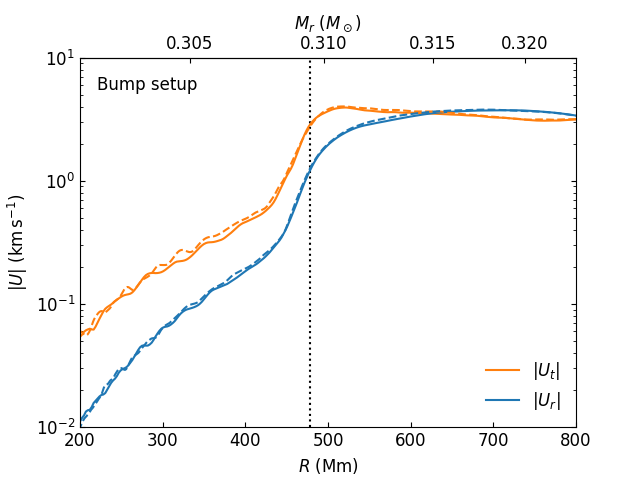

In [24]:
ylabel_='$|U|$ (km$\,$s$^{-1}$)'; yylim=(-1,None)
vars = ['|Ut|','Ur','|U|Max']
vars = ['|Ut|','|Ur|']
#xthing = 'm'  ; xxlim = (0,0.1)   ; xlabel_ = '$m / M_\odot$'
xthing = 'R'  ; xxlim = (None,None) ; xlabel_ = '$R$ (Mm)'

logy = True
logy = False

ifig = 120; close(ifig)

fig = plt.figure(ifig)
xlim(200,800)
ylim(0.01,10)
i = 0 
# for case in plots['cases']:
for jj,case in enumerate(casesbump):
    print(case)
    if jj==0:
        ls = '-'
    else:
        ls = '--'
    for j,dump in enumerate(plots['dumps'][case]):
        for k,var in enumerate(vars):
            i += 1
            if 'Ut' in var:
                color='tab:orange'
                varl = '$|U_t|$'
            else:
                color='tab:blue'
                varl = '$|U_r|$'
            label=var+'/hrs'+"{:.0f}".format(dump/3600)
            if jj==0:
                semilogy(data[case][dump][xthing],(1000*data[case][dump][var]),
                             ls=ls, color=color, label=varl)
            else:
                semilogy(data[case][dump][xthing],(1000*data[case][dump][var]),
                             ls=ls, color=color)

legend(frameon=False, loc=4)
xlabel(xlabel_)
ylabel(ylabel_)

rtom = interp1d(data[case][dump]['R'], data[case][dump]['m'], fill_value='extrapolate')
mtor = interp1d(data[case][dump]['m'], data[case][dump]['R'], fill_value='extrapolate')
ax1 = plt.gca()
secax = ax1.secondary_xaxis('top', functions=(rtom, mtor))
secax.set_xlabel('$M_r$ ($M_\odot$)')
secax.set_xticks([0.3,0.305,0.31,0.315,0.32,0.325])

vlines(data[case][dump]['bound_rad_R'],1e-2,10,ls=':',color='k')

secax.tick_params(axis='both',direction='in', which='both')
ax1.tick_params(axis='both',direction='in', which='both')
ax1.yaxis.set_ticks_position('both')
#ax1.xaxis.set_ticks_position('both')
text(220,5.5,'Bump setup')
savefig('velcomp_bump.pdf', bbox_inches='tight')

niagara_scratch_fherwig/X24-1xL-1xK-heating-768-mc12400-rin40-P0fix-kappamod
frontera_scratch3_mao1/X26-1xL-1xK-1536-mc12400


/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


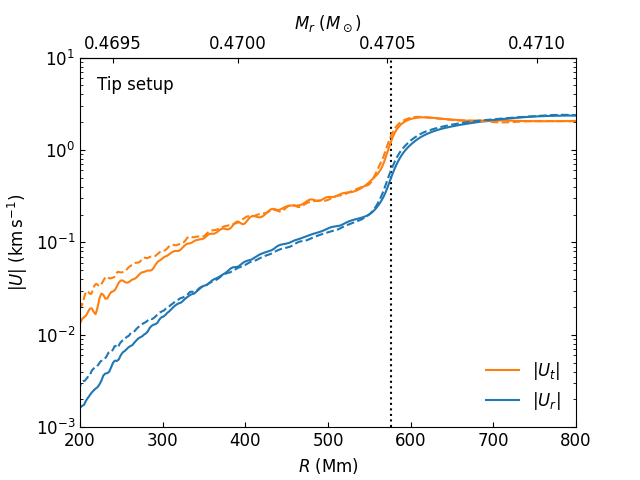

In [25]:
ylabel_='$|U|$ (km$\,$s$^{-1}$)'; yylim=(-1,None)
vars = ['|Ut|','Ur','|U|Max']
vars = ['|Ut|','|Ur|']
#xthing = 'm'  ; xxlim = (0,0.1)   ; xlabel_ = '$m / M_\odot$'
xthing = 'R'  ; xxlim = (None,None) ; xlabel_ = '$R$ (Mm)'

logy = True
logy = False

ifig = 121; close(ifig)

fig = plt.figure(ifig)
xlim(200,800)
ylim(0.001,10)
i = 0 
# for case in plots['cases']:
for jj,case in enumerate(casestip):
    print(case)
    if jj==0:
        ls = '-'
    else:
        ls = '--'
    for j,dump in enumerate(plots['dumps'][case]):
        for k,var in enumerate(vars):
            i += 1
            if 'Ut' in var:
                color='tab:orange'
                varl = '$|U_t|$'
            else:
                color='tab:blue'
                varl = '$|U_r|$'
            label=var+'/hrs'+"{:.0f}".format(dump/3600)
            if jj==0:
                semilogy(data[case][dump][xthing],(1000*data[case][dump][var]),
                             ls=ls, color=color, label=varl)
            else:
                semilogy(data[case][dump][xthing],(1000*data[case][dump][var]),
                             ls=ls, color=color)

legend(frameon=False, loc=4)
xlabel(xlabel_)
ylabel(ylabel_)

rtom = interp1d(data[case][dump]['R'], data[case][dump]['m'], fill_value='extrapolate')
mtor = interp1d(data[case][dump]['m'], data[case][dump]['R'], fill_value='extrapolate')
ax1 = plt.gca()
secax = ax1.secondary_xaxis('top', functions=(rtom, mtor))
secax.set_xlabel(r'$M_r$ ($M_\odot$)')
secax.set_xticks([.4695,.470,.4705,.471])

vlines(data[case][dump]['bound_rad_R'],1e-3,10,ls=':',color='k')

secax.tick_params(axis='both',direction='in', which='both')
ax1.tick_params(axis='both',direction='in', which='both')
ax1.yaxis.set_ticks_position('both')
#ax1.xaxis.set_ticks_position('both')
text(220,4.5,'Tip setup')
savefig('velcomp_tip.pdf', bbox_inches='tight')

## Mach numbers

niagara_scratch_fherwig/X14-1000xL-1000xK-heating-768-mc2400-rin40
frontera_scratch3_mao1/X22-1000xL-1000xK-heating-1536-mc2400-rin40


/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


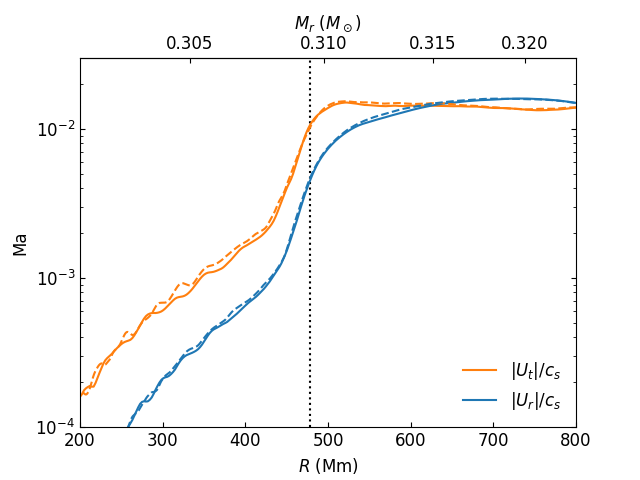

In [36]:
ylabel_='Ma'; yylim=(-1,None)
vars = ['|Ut|','Ur','|U|Max']
vars = ['|Ut|','|Ur|']
#xthing = 'm'  ; xxlim = (0,0.1)   ; xlabel_ = '$m / M_\odot$'
xthing = 'R'  ; xxlim = (None,None) ; xlabel_ = '$R$ (Mm)'

logy = True
logy = False

ifig = 130; close(ifig)

fig = plt.figure(ifig)
xlim(200,800)
ylim(0.0001,0.03)
i = 0 
# for case in plots['cases']:
for jj,case in enumerate(casesbump):
    print(case)
    if jj==0:
        ls = '-'
    else:
        ls = '--'
    for j,dump in enumerate(plots['dumps'][case]):
        for k,var in enumerate(vars):
            i += 1
            if 'Ut' in var:
                color='tab:orange'
                varl = '$|U_t|/c_s$'
            else:
                color='tab:blue'
                varl = '$|U_r|/c_s$'
            label=var+'/hrs'+"{:.0f}".format(dump/3600)
            if jj==0:
                semilogy(data[case][dump][xthing],(data[case][dump][var]/data[case][dump]['csound']),
                             ls=ls, color=color, label=varl)
            else:
                semilogy(data[case][dump][xthing],(data[case][dump][var]/data[case][dump]['csound']),
                             ls=ls, color=color)

legend(frameon=False, loc=4)
xlabel(xlabel_)
ylabel(ylabel_)

rtom = interp1d(data[case][dump]['R'], data[case][dump]['m'], fill_value='extrapolate')
mtor = interp1d(data[case][dump]['m'], data[case][dump]['R'], fill_value='extrapolate')
ax1 = plt.gca()
secax = ax1.secondary_xaxis('top', functions=(rtom, mtor))
secax.set_xlabel('$M_r$ ($M_\odot$)')
secax.set_xticks([0.3,0.305,0.31,0.315,0.32,0.325])

vlines(data[case][dump]['bound_rad_R'],1e-4,10,ls=':',color='k')

secax.tick_params(axis='both',direction='in', which='both')
ax1.tick_params(axis='both',direction='in', which='both')
ax1.yaxis.set_ticks_position('both')
#ax1.xaxis.set_ticks_position('both')
text(220,5.5,'Bump setup')
savefig('mach_bump.pdf', bbox_inches='tight')

niagara_scratch_fherwig/X24-1xL-1xK-heating-768-mc12400-rin40-P0fix-kappamod
frontera_scratch3_mao1/X26-1xL-1xK-1536-mc12400


/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


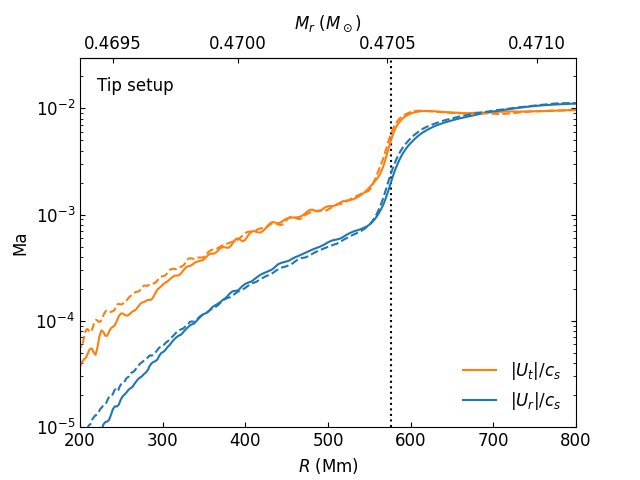

In [43]:
ylabel_='Ma'; yylim=(-1,None)
vars = ['|Ut|','Ur','|U|Max']
vars = ['|Ut|','|Ur|']
#xthing = 'm'  ; xxlim = (0,0.1)   ; xlabel_ = '$m / M_\odot$'
xthing = 'R'  ; xxlim = (None,None) ; xlabel_ = '$R$ (Mm)'

logy = True
logy = False

ifig = 131; close(ifig)

fig = plt.figure(ifig)
xlim(200,800)
ylim(0.00001,0.03)
i = 0 
# for case in plots['cases']:
for jj,case in enumerate(casestip):
    print(case)
    if jj==0:
        ls = '-'
    else:
        ls = '--'
    for j,dump in enumerate(plots['dumps'][case]):
        for k,var in enumerate(vars):
            i += 1
            if 'Ut' in var:
                color='tab:orange'
                varl = '$|U_t|/c_s$'
            else:
                color='tab:blue'
                varl = '$|U_r|/c_s$'
            label=var+'/hrs'+"{:.0f}".format(dump/3600)
            if jj==0:
                semilogy(data[case][dump][xthing],(data[case][dump][var]/data[case][dump]['csound']),
                             ls=ls, color=color, label=varl)
            else:
                semilogy(data[case][dump][xthing],(data[case][dump][var]/data[case][dump]['csound']),
                             ls=ls, color=color)

legend(frameon=False, loc=4)
xlabel(xlabel_)
ylabel(ylabel_)

rtom = interp1d(data[case][dump]['R'], data[case][dump]['m'], fill_value='extrapolate')
mtor = interp1d(data[case][dump]['m'], data[case][dump]['R'], fill_value='extrapolate')
ax1 = plt.gca()
secax = ax1.secondary_xaxis('top', functions=(rtom, mtor))
secax.set_xlabel(r'$M_r$ ($M_\odot$)')
secax.set_xticks([.4695,.470,.4705,.471])

vlines(data[case][dump]['bound_rad_R'],1e-5,10,ls=':',color='k')

secax.tick_params(axis='both',direction='in', which='both')
ax1.tick_params(axis='both',direction='in', which='both')
ax1.yaxis.set_ticks_position('both')
#ax1.xaxis.set_ticks_position('both')
text(220,1.44e-2,'Tip setup')
savefig('mach_tip.pdf', bbox_inches='tight')